In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [137]:
pd.set_option('display.min_rows', 100)

In [138]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)(np.linspace(0.1, 0.8, n))

In [139]:
with open("metrics_cached_12n_8p_64b_1cu_local.json") as f:
    raw = json.load(f)
points = pd.json_normalize(raw)
points.rename(columns={
    "labels.status": "status", 
    "labels.provider": "provider",
    "labels.size": "size",
    "labels.epoch": "epoch",
    "labels.action": "action"
}, inplace=True)
points["end"] = points['start'] + points['duration']

In [140]:
estimate = points[points["action"] == "estimate"]
send = points[points["action"] == "send"]

confirmed = points[points["status"] == "confirmed"].sort_values(by='start')
success = send[send["status"] == "success"].sort_values(by='start')
success_est = estimate[estimate["status"] == "success"].sort_values(by='start')
invalid_est = estimate[estimate["status"] == "invalid"].sort_values(by='start')

In [141]:
success.shape

(372, 17)

In [142]:
success_est.shape

(382, 17)

In [143]:
success["duration"].median()

7410.267436027527

In [144]:
confirmed["duration"].median()

19715.587077856064

In [145]:
epoches = points[points["status"] == "success"][["start", "end", "epoch"]].copy()
epoches = epoches.groupby("epoch").agg(start=('start', 'min'), end=('end', 'max')).reset_index()
epoches["end"] = epoches["end"]
epoches["duration"] = epoches["end"] - epoches["start"]

In [146]:
epoches

,epoch,start,end,duration
0,18,3.187782e+06,3.491462e+06,303679.228837
1,19,3.577518e+06,3.785238e+06,207720.506776
2,20,3.874128e+06,4.089292e+06,215163.838597
3,21,4.186179e+06,4.384632e+06,198452.728930


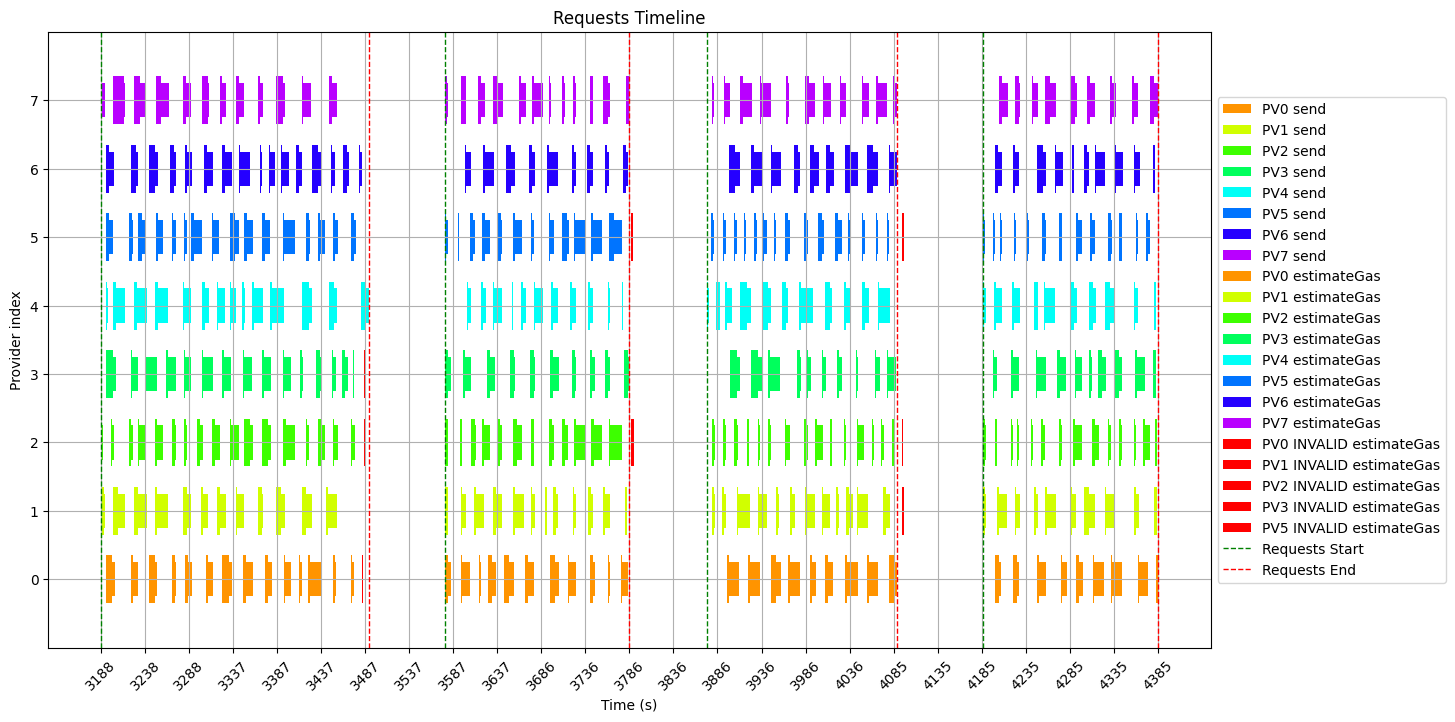

In [147]:
FACTOR = 1e3
count = len(points['provider'].unique())
plt.figure(figsize=(15, count))
cmap = get_cmap(count)

def plot_duration(data, name, th, colors):
    for i, (pv, group) in enumerate(data.groupby('provider')):
        data = list(zip(group['start'] / FACTOR, group['duration']  / FACTOR))
        pnum = int(pv[2:])
        label = pv + " " + name
        color = colors if isinstance(colors, str) else colors[i]
        plt.broken_barh(data, (pnum-th/2, th), facecolor=color, label=label)

#plot_duration(confirmed, "estimateGas", 0.2, cmap)
plot_duration(success, "send", 0.5, cmap)
plot_duration(success_est, "estimateGas", 0.7, cmap)
plot_duration(invalid_est, "INVALID estimateGas", 0.7, "red")

for i, row in epoches.iterrows():
    plt.axvline(x=row['start'] / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    plt.axvline(x=row['end'] / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

# Formatting
plt.xticks(np.linspace(success_est["start"].min() / FACTOR, success_est["end"].max() / FACTOR, 25), rotation=45)
plt.yticks(np.linspace(0, count - 1, count))

plt.xlabel('Time (s)')
plt.ylabel('Provider index')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, count)
plt.grid(True)
plt.show()

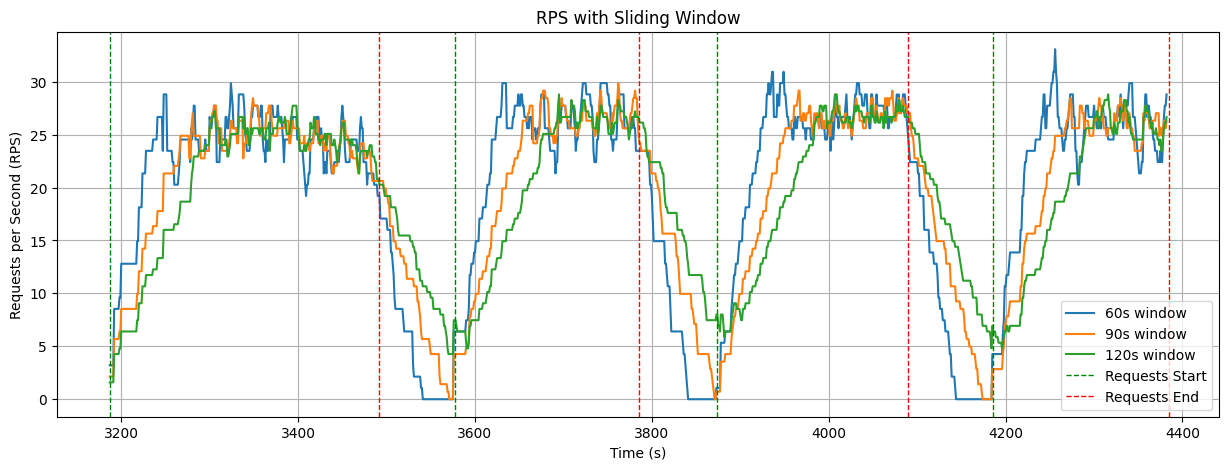

In [148]:
reqs = success_est[["start", "size"]].copy()
reqs["start"] = pd.to_timedelta(reqs["start"], unit="ms")
reqs = reqs.groupby("start")["size"].sum()

# Resample to 1-second frequency
resampled = reqs.resample('1s').sum()

FACTOR = 1e9
def plot_window(window_size):
    rps = resampled.rolling(window=window_size, min_periods=0).sum() / window_size
    plt.plot(rps.index / FACTOR, rps.values, label="{}s window".format(window_size))

plt.figure(figsize=(15, 5))
# Plot
plot_window(60)
plot_window(90)
plot_window(120)

for i, row in epoches.iterrows():
    start = pd.to_timedelta(row['start'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=start / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    end = pd.to_timedelta(row['end'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=end / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Requests per Second (RPS)')
plt.title('RPS with Sliding Window')
plt.grid(True)
plt.legend()
plt.show()

In [149]:
erps = []
for (i, epoch) in epoches.iterrows():
    if i == 5:
        continue
    count = success[success["epoch"] == epoch["epoch"]]["size"].sum()
    rps = count / epoch["duration"] * 1000
    erps.append(rps)
    print(rps)
erps = pd.Series(erps)
erps.median(), erps.min(), erps.max()

24.446848170786527
26.497143134448326
27.067745388727474
25.477099898099596


(25.98712151627396, 24.446848170786527, 27.067745388727474)

Text(0, 0.5, 'RPS')

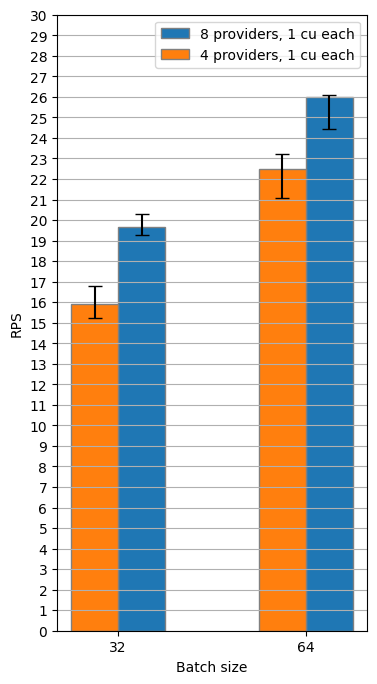

In [151]:
batches =                     ["32",  "64"]
batches_rps = {
    "8 providers, 1 cu each": [19.67, 25.99],
    "4 providers, 1 cu each": [15.92, 22.51],
}
batches_rps_min =  {
    "8 providers, 1 cu each": [19.29, 24.45],
    "4 providers, 1 cu each": [15.21, 21.07],
}
batches_rps_max =  {
    "8 providers, 1 cu each": [20.31, 26.07],
    "4 providers, 1 cu each": [16.80, 23.20],
}
barWidth = 0.5

plt.figure(figsize=(len(batches) * 2, 8))

n_modes = len(batches_rps)
n_batches = len(batches)
rps_x = np.arange(0, n_batches * 2, 2)

for i, (mode, rps) in enumerate(batches_rps.items()):
  x = rps_x + barWidth * ((n_modes - 1) / 2 - i)
  x = x[:len(rps)]
  plt.bar(x, rps, width=barWidth, edgecolor='grey', label=mode)
  rps_min = batches_rps_min.get(mode, [])
  rps_max = batches_rps_max.get(mode, [])
  for pos, me, mi, ma in zip(x, rps, rps_min, rps_max):
    plt.errorbar(pos, me, yerr=[[me - mi], [ma - me]], fmt='', color='black', capsize=5)

plt.legend()
plt.grid(True, axis="y")
plt.xticks(rps_x, batches)
plt.yticks(np.linspace(0, 30, 31))
plt.xlabel("Batch size")
plt.ylabel("RPS")

Text(0, 0.5, 'RPS')

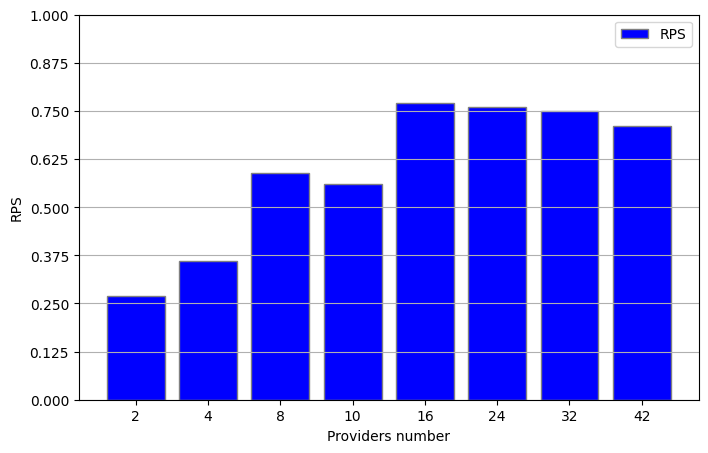

In [457]:
providers = ["2", "4", "8", "10", "16", "24", "32", "42"]
providers_rps = [0.27, 0.36, 0.59, 0.56, 0.77, 0.76, 0.75, 0.71]
barWidth = 0.8

plt.figure(figsize=(len(providers), 5))

n_providers = len(providers)
rps_x = np.arange(n_providers)

plt.bar(rps_x, providers_rps, color='blue', width=barWidth, edgecolor='grey', label='RPS')

plt.legend()
plt.grid(True, axis="y")
plt.xticks(range(n_providers), providers)
plt.yticks(np.linspace(0, 1, 9))
plt.xlabel("Providers number")
plt.ylabel("RPS")

Text(0, 0.5, 'Frequency')

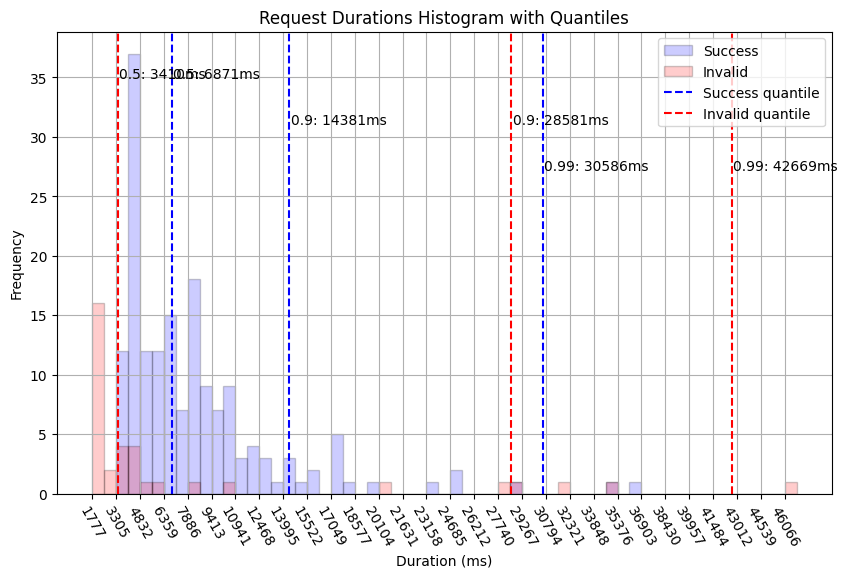

In [458]:
q = [0.5, 0.9, 0.99]

# Plot histogram
plt.figure(figsize=(10, 6))
#space = np.logspace(np.log10(success['duration'].min()), np.log10(success['duration'].max()), 100)
mind = min(invalid_est["duration"].min(), success_est["duration"].min())
maxd = max(invalid_est["duration"].max(), success_est["duration"].max())

space = np.linspace(mind, maxd, 60)
plt.hist(success_est['duration'], bins=space, alpha=0.2, color='blue', edgecolor='black', label="Success")
plt.hist(invalid_est['duration'], bins=space, alpha=0.2, color='red', edgecolor='black', label="Invalid")

# Annotate quantiles
def plot_q(qs, name, color):
    for i, quantile in enumerate(qs):
        plt.axvline(x=quantile, color=color, linestyle='--', label=(name + " quantile") if i == 0 else "")
        plt.text(
            quantile + 100, plt.ylim()[1]*(9 - i)*0.1, 
            f'{q[i]}: {quantile:.0f}ms', horizontalalignment='left', color='black',
        )
        
plot_q(success_est['duration'].quantile(q), "Success", "blue")
plot_q(invalid_est['duration'].quantile(q), "Invalid", "red")

plt.xticks(space[::2], rotation=-60)
plt.legend()
plt.grid()
plt.title('Request Durations Histogram with Quantiles')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

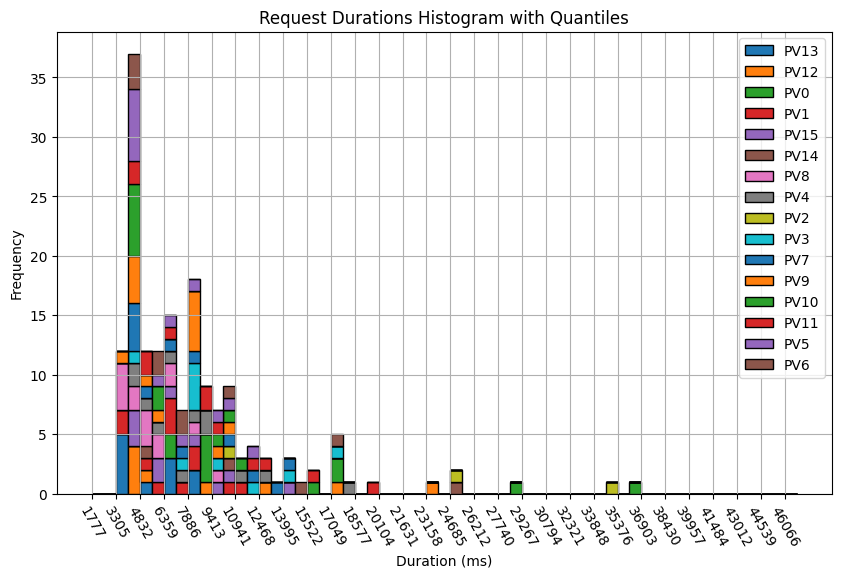

In [459]:
# Plot histogram
plt.figure(figsize=(10, 6))
# From the pevious chart
mind = min(invalid_est["duration"].min(), success_est["duration"].min())
maxd = max(invalid_est["duration"].max(), success_est["duration"].max())
space = np.linspace(mind, maxd, 60)
providers = success_est["provider"].unique()
data = [success_est[success_est["provider"] == pv]['duration'] for pv in providers]
plt.hist(data, stacked=True, bins=space, edgecolor='black', label=providers)

plt.xticks(space[::2], rotation=-60)
plt.legend()
plt.grid()
plt.title('Request Durations Histogram with Quantiles')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

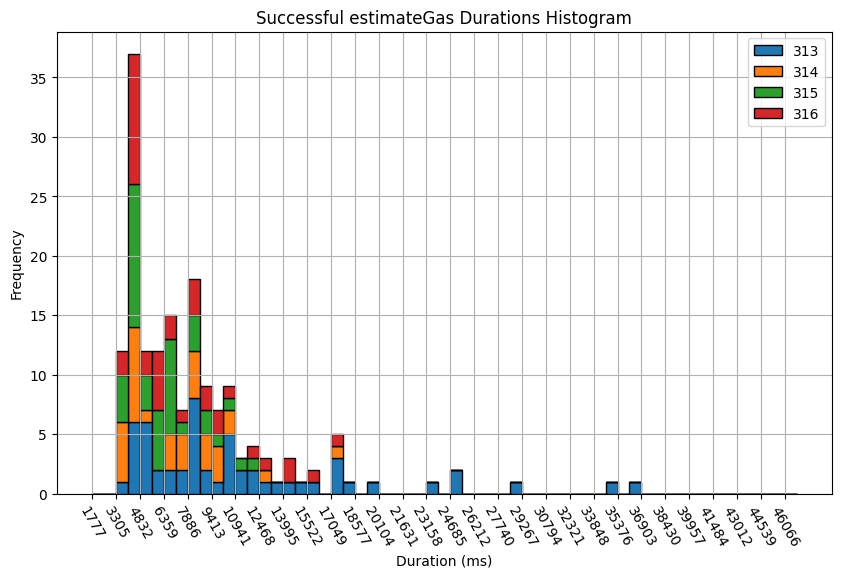

In [460]:
# Plot histogram
plt.figure(figsize=(10, 6))

# From the previos chart
mind = min(invalid_est["duration"].min(), success_est["duration"].min())
maxd = max(invalid_est["duration"].max(), success_est["duration"].max())

space = np.linspace(mind, maxd, 60)
epoches = success_est["epoch"].unique()
data = [success_est[success_est["epoch"] == ep]['duration'] for ep in epoches]
plt.hist(data, stacked=True, bins=space, edgecolor='black', label=epoches)

plt.xticks(space[::2], rotation=-60)
plt.legend()
plt.grid()
plt.title('Successful estimateGas Durations Histogram')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

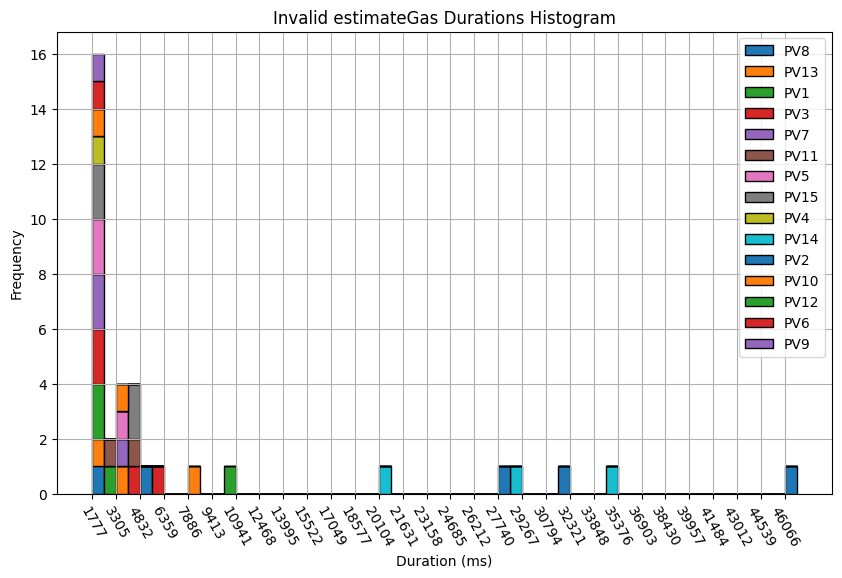

In [461]:
# Plot histogram
plt.figure(figsize=(10, 6))

# From the previos chart
mind = min(invalid_est["duration"].min(), success_est["duration"].min())
maxd = max(invalid_est["duration"].max(), success_est["duration"].max())

space = np.linspace(mind, maxd, 60)
providers = invalid_est["provider"].unique()
data = [invalid_est[invalid_est["provider"] == pv]['duration'] for pv in providers]
plt.hist(data, stacked=True, bins=space, edgecolor='black', label=providers)

plt.xticks(space[::2], rotation=-60)
plt.legend()
plt.grid()
plt.title('Invalid estimateGas Durations Histogram')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

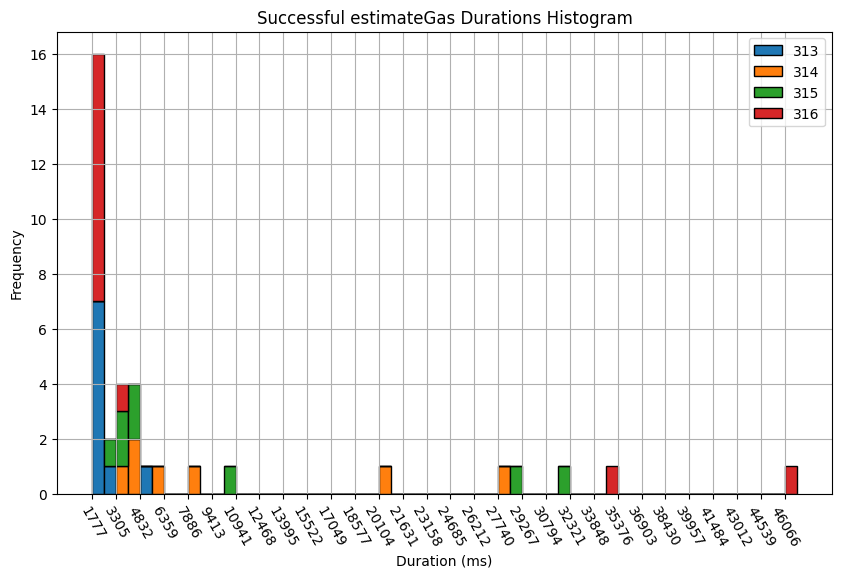

In [462]:
# Plot histogram
plt.figure(figsize=(10, 6))

# From the previos chart
mind = min(invalid_est["duration"].min(), success_est["duration"].min())
maxd = max(invalid_est["duration"].max(), success_est["duration"].max())

space = np.linspace(mind, maxd, 60)
epoches = invalid_est["epoch"].unique()
data = [invalid_est[invalid_est["epoch"] == ep]['duration'] for ep in epoches]
plt.hist(data, stacked=True, bins=space, edgecolor='black', label=epoches)

plt.xticks(space[::2], rotation=-60)
plt.legend()
plt.grid()
plt.title('Successful estimateGas Durations Histogram')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

Text(0, 0.5, 'RPS')

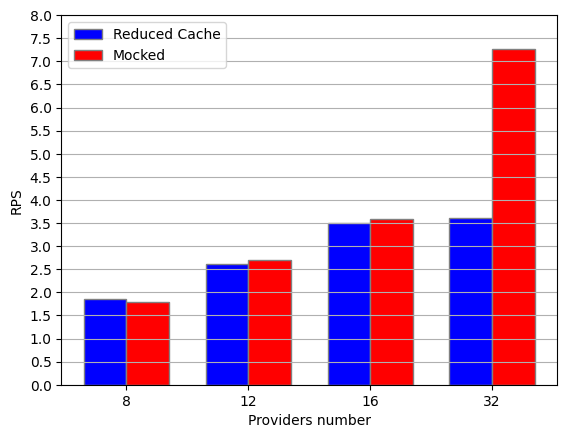

In [463]:
providers = ["8", "12", "16", "32"]
providers_rps = [1.85, 2.62, 3.5, 3.61]
providers_m_rps = [1.79, 2.70, 3.58, 7.26]

n_providers = len(providers)
barWidth = 0.35
rps_x = np.arange(n_providers)
rps_m_x = [x + barWidth for x in rps_x]

plt.bar(rps_x, providers_rps, color='blue', width=barWidth, edgecolor='grey', label='Reduced Cache')
plt.bar(rps_m_x, providers_m_rps, color='red', width=barWidth, edgecolor='grey', label='Mocked')

plt.legend()
plt.grid(True, axis="y")
plt.xticks([r + barWidth/2 for r in range(n_providers)], providers)
plt.yticks(np.linspace(0, 8, 17))
plt.xlabel("Providers number")
plt.ylabel("RPS")

In [464]:
def process(datas):
    res = dict()
    for line in datas.split("\n"):
        words = line.split(" ")
        res[words[0]] = list(map(float, words[-3:]))
    return res

batches = dict()
batches["1"] = """from_raw 2137 1.4016078614881 1.67 1.7792 1.96
pack 2129 476299.10615312 484829.4 486830.4 491330.6
randomx 2129 476283.73461719 484815 486815.2 491316.76"""
batches["2"] = """from_raw 2093 1.4917166746297 1.8 1.91 2.1916
pack 2094 598354.48185291 626291.3 629699.4 636137.91
randomx 2094 598336.06064947 626273.6 629677 636121.35"""
batches["3"] = """from_raw 2245 1.5433224944321 1.9 2.0308 2.33
pack 2236 726489.93872987 761149 767902.5 780270.95
randomx 2236 726470.12209302 761130.5 767885 780253.65"""
batches["4"] = """from_raw 2134 1.6584062792877 2.071 2.26 2.6867
pack 2125 873428.26588235 942962.6 957103.2 976011.52
randomx 2125 873406.89647059 942941 957080.4 975992.8"""

batches = {k: process(v) for k, v in batches.items()}

In [465]:
batches

{'1': {'from_raw': [1.67, 1.7792, 1.96],
  'pack': [484829.4, 486830.4, 491330.6],
  'randomx': [484815.0, 486815.2, 491316.76]},
 '2': {'from_raw': [1.8, 1.91, 2.1916],
  'pack': [626291.3, 629699.4, 636137.91],
  'randomx': [626273.6, 629677.0, 636121.35]},
 '3': {'from_raw': [1.9, 2.0308, 2.33],
  'pack': [761149.0, 767902.5, 780270.95],
  'randomx': [761130.5, 767885.0, 780253.65]},
 '4': {'from_raw': [2.071, 2.26, 2.6867],
  'pack': [942962.6, 957103.2, 976011.52],
  'randomx': [942941.0, 957080.4, 975992.8]}}

Text(0, 0.5, 'Time (us)')

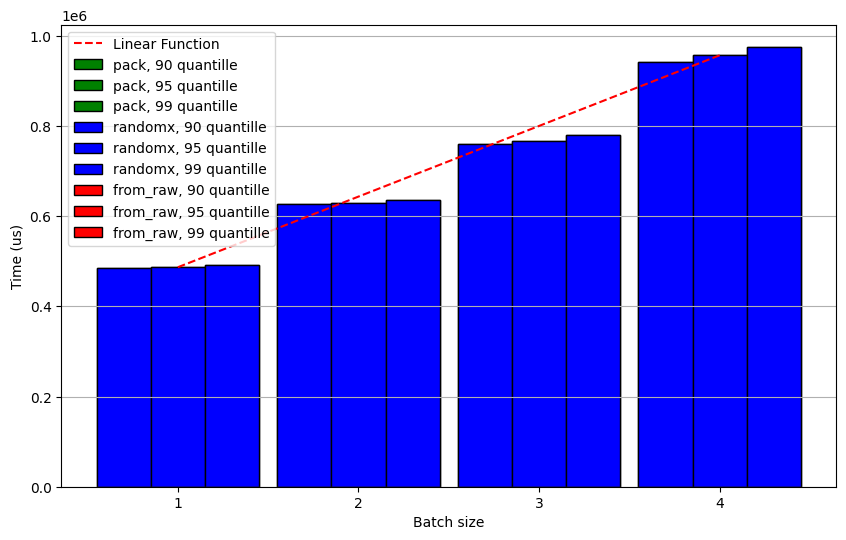

In [466]:
plt.figure(figsize=(10, 6))

x_range = [int(b) for b in batches]
width = 0.3
colors = {
    "from_raw": "red",
    "randomx": "blue",
    "pack": "green"
}
quants = {
    0: "90",
    1: "95",
    2: "99"
}

for process in ["pack", "randomx", "from_raw"]:
    for q, qlabel in quants.items():
        x_r = [x - width * (len(quants) // 2 - q) for x in x_range]
        values = [v[process][q] for v in batches.values()]
        plt.bar(x_r, values, width, color=colors[process], edgecolor="black", label=f"{process}, {qlabel} quantille")

x = [min(x_range), max(x_range)]
y = [batches["1"]["randomx"][1], batches["4"]["randomx"][1]]

plt.plot(x, y, color="red", linestyle="--", label="Linear Function")

plt.legend()
plt.grid(True, axis="y")
plt.xticks(x_range, batches.keys())
plt.xlabel("Batch size")
plt.ylabel("Time (us)")

In [480]:
96 * 96 / 2 / 1024

4.5